In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [2]:
from torch import cuda
device = 'cuda:1' if cuda.is_available() else 'cpu'

In [3]:
train_dataset = pd.read_csv("./save_not_reduced_bert/train.csv")
test_dataset = pd.read_csv("./save_not_reduced_bert/test.csv")
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

train_dataset['list'] = train_dataset.iloc[:,1:].values.astype(int).tolist()
test_dataset['list'] = test_dataset.iloc[:,1:].values.astype(int).tolist()

train_dataset = train_dataset[['news', 'list']].rename(columns={"news": "comment_text"})
test_dataset = test_dataset[['news', 'list']].rename(columns={"news": "comment_text"})

TRAIN Dataset: (5956, 11)
TEST Dataset: (1489, 11)


<AxesSubplot:ylabel='Frequency'>

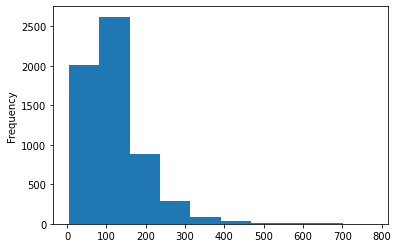

In [4]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset.comment_text.str.split().str.len().plot.hist()

In [5]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True  #####   TODO
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [6]:
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [7]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# Creating the Neural Network for Fine Tuning

In [8]:
class BERTClass(torch.nn.Module):
    def __init__(self, num_class):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, num_class)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

num_class = len(test_dataset.list[0])    
    
model = BERTClass(num_class)
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [9]:
model.load_state_dict(torch.load('save_not_reduced_bert/transformer.pth'))

<All keys matched successfully>

In [10]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Fine Tuning the Model

In [11]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [24]:
# EPOCHS=10

In [25]:
# for epoch in range(10,20):
#     print('\n')
#     train(epoch)
        
#     outputs, targets = validation(epoch)
#     outputs = np.array(outputs) >= 0.5
#     accuracy = accuracy_score(targets, outputs)
#     f1_score_micro = f1_score(targets, outputs, average='micro')
#     f1_score_macro = f1_score(targets, outputs, average='macro')
#     print(f"Accuracy Score = {accuracy}")
#     print(f"F1 Score (Micro) = {f1_score_micro}")
#     print(f"F1 Score (Macro) = {f1_score_macro}")



Epoch: 0, Loss:  0.6830872297286987
Accuracy Score = 0.7696440564137005
F1 Score (Micro) = 0.013531799729364004
F1 Score (Macro) = 0.002873563218390805


Epoch: 1, Loss:  0.15556316077709198
Accuracy Score = 0.7877770315648086
F1 Score (Micro) = 0.6592178770949721
F1 Score (Macro) = 0.19440961995407466


Epoch: 2, Loss:  0.08720336854457855
Accuracy Score = 0.8334452652787105
F1 Score (Micro) = 0.7236842105263159
F1 Score (Macro) = 0.22978943558714898


Epoch: 3, Loss:  0.09913261234760284
Accuracy Score = 0.8361316319677636
F1 Score (Micro) = 0.7513368983957219
F1 Score (Macro) = 0.274734312645626


Epoch: 4, Loss:  0.04411693289875984
Accuracy Score = 0.8703828072531901
F1 Score (Micro) = 0.7779390420899855
F1 Score (Macro) = 0.34434495201066284


Epoch: 5, Loss:  0.019549701362848282
Accuracy Score = 0.867696440564137
F1 Score (Micro) = 0.7774725274725275
F1 Score (Macro) = 0.37330630000832205


Epoch: 6, Loss:  0.036784976720809937
Accuracy Score = 0.8636668905305575
F1 Score (Mi

In [11]:
# torch.save(model.state_dict(), 'save_not_reduced_bert/transformer20.pth')
# model.load_state_dict(torch.load('save_not_reduced_bert/transformer.pth'))

<All keys matched successfully>

In [12]:
for epoch in range(10,20):
    print('\n')
    train(epoch)
        
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = accuracy_score(targets, outputs)
    f1_score_micro = f1_score(targets, outputs, average='micro')
    f1_score_macro = f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")



Epoch: 10, Loss:  0.015894897282123566
Accuracy Score = 0.8791134989926125
F1 Score (Micro) = 0.782312925170068
F1 Score (Macro) = 0.4235835272861285


Epoch: 11, Loss:  0.01973828114569187
Accuracy Score = 0.8717259905977166
F1 Score (Micro) = 0.773936170212766
F1 Score (Macro) = 0.41171818120832526


Epoch: 12, Loss:  0.01271072681993246
Accuracy Score = 0.8797850906648758
F1 Score (Micro) = 0.7826086956521741
F1 Score (Macro) = 0.4287930543884787


Epoch: 13, Loss:  0.04059185832738876
Accuracy Score = 0.8777703156480859
F1 Score (Micro) = 0.7774725274725275
F1 Score (Macro) = 0.4393664359978805


Epoch: 14, Loss:  0.013645203784108162
Accuracy Score = 0.8744123572867697
F1 Score (Micro) = 0.7756452680344144
F1 Score (Macro) = 0.43572146525521427


Epoch: 15, Loss:  0.025084471330046654
Accuracy Score = 0.8770987239758227
F1 Score (Micro) = 0.7765667574931879
F1 Score (Macro) = 0.4314090688404707


Epoch: 16, Loss:  0.006465205457061529
Accuracy Score = 0.8629952988582942
F1 Score

In [13]:
torch.save(model.state_dict(), 'save_not_reduced_bert/transformer20.pth')

In [14]:
outputs, targets = validation(epoch)
outputs = np.array(outputs)
targets = np.array(targets)

In [15]:
import pickle

with open('save_not_reduced_bert/outputs20.pt', 'wb') as file:
    pickle.dump(outputs, file)
    
with open('save_not_reduced_bert/targets20.pt', 'wb') as file:
    pickle.dump(targets, file)


In [16]:
df = pd.DataFrame(columns = ['threshold','type','accuracy', 
                             'recall(micro)', 'precision(micro)', 'f1(micro)', 
                             'recall(macro)', 'precision(macro)', 'f1(macro)', 
                            ])

Threshold = np.around(np.linspace(0.1, 0.9, 9),1)

for threshold in Threshold:
    print('threshold', threshold)
    pred = outputs >= threshold

    df.loc[len(df)] = [threshold, 
                       'all', 
                       accuracy_score(targets, pred),
                       recall_score(targets, pred, average='micro'),
                       precision_score(targets, pred, average='micro'),
                       f1_score(targets, pred, average='micro'),
                       recall_score(targets, pred, average='macro'),
                       precision_score(targets, pred, average='macro'),
                       f1_score(targets, pred, average='macro')
                       ]
    
    
    df.loc[len(df)] = [threshold, 
                       'multi', 
                       accuracy_score(targets[:,1:], pred[:,1:]),
                       recall_score(targets[:,1:], pred[:,1:], average='micro'),
                       precision_score(targets[:,1:], pred[:,1:], average='micro'),
                       f1_score(targets[:,1:], pred[:,1:], average='micro'),
                       recall_score(targets[:,1:], pred[:,1:], average='macro'),
                       precision_score(targets[:,1:], pred[:,1:], average='macro'),
                       f1_score(targets[:,1:], pred[:,1:], average='macro')
                       ]
    
    
    
    df_target = pd.DataFrame(targets)
    df_target.columns = ['is_relevant', 'Armed Assault', 'Assassination',
       'Barricade Incident', 'Bombing/Explosion',
       'Facility/Infrastructure Attack', 'Hijacking', 'Kidnapping',
       'Unarmed Assault', 'Unknown']

    df_pred = pd.DataFrame(pred)
    df_pred.columns = df_target.columns
    
    for col in df_pred.columns:

        df.loc[len(df)] = [threshold, 
                           col, 
                           accuracy_score(df_target[col], df_pred[col]),
                           recall_score(df_target[col], df_pred[col], average='micro'),
                           precision_score(df_target[col], df_pred[col], average='micro'),
                           f1_score(df_target[col], df_pred[col], average='micro'),
                           recall_score(df_target[col], df_pred[col], average='macro'),
                           precision_score(df_target[col], df_pred[col], average='macro'),
                           f1_score(df_target[col], df_pred[col], average='macro')
                           ]


threshold 0.1
threshold 0.2


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold 0.3
threshold 0.4
threshold 0.5
threshold 0.6
threshold 0.7
threshold 0.8
threshold 0.9


In [17]:
df.to_csv('save_not_reduced_bert/saved_df20.csv')

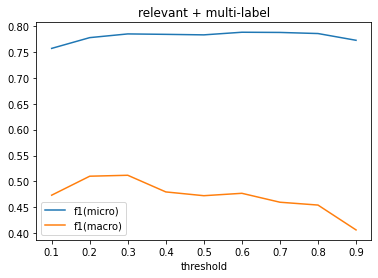

In [18]:
df_select = df[df.type == 'all'][['f1(micro)','f1(macro)']].reset_index(drop=True);
ax = df_select.plot(xticks=df_select.index, title = 'relevant + multi-label', );
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

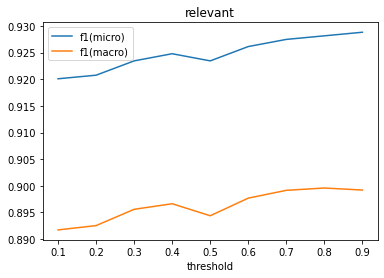

In [19]:
df_select = df[df.type == 'is_relevant'][['f1(micro)','f1(macro)']].reset_index(drop=True)
ax = df_select.plot(xticks=df_select.index, title = 'relevant');
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

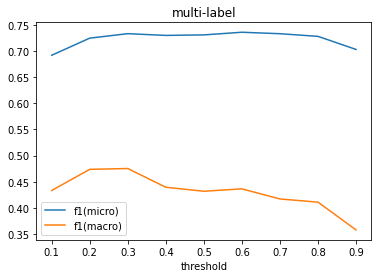

In [20]:
df_select = df[df.type == 'multi'][['f1(micro)','f1(macro)']].reset_index(drop=True)
ax = df_select.plot(xticks=df_select.index, title = 'multi-label');
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

                             type  f1(micro)  f1(macro)
0                   Armed Assault   0.948287   0.859367
1                   Assassination   0.995299   0.680639
2              Barricade Incident   0.999328   0.499832
3               Bombing/Explosion   0.973136   0.917993
4  Facility/Infrastructure Attack   0.983882   0.819406
5                       Hijacking   0.998657   0.499664
6                      Kidnapping   0.989926   0.823026
7                 Unarmed Assault   0.990598   0.560137
8                         Unknown   0.982539   0.745557


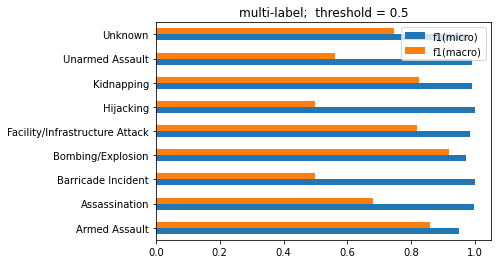

In [21]:
df_select = df[df.type.isin(df_target.columns[1:]) ]
df_select = df_select[df_select.threshold == 0.5][['type','f1(micro)','f1(macro)']]
df_select = df_select.reset_index(drop=True)
print(df_select)
ax = df_select.plot.barh(title = 'multi-label;  threshold = 0.5');
ax.set_yticklabels(df_target.columns[1:]);

                             type  f1(micro)  f1(macro)
0                   Armed Assault   0.950302   0.862033
1                   Assassination   0.995299   0.680639
2              Barricade Incident   0.999328   0.499832
3               Bombing/Explosion   0.973136   0.917993
4  Facility/Infrastructure Attack   0.985897   0.834857
5                       Hijacking   0.998657   0.499664
6                      Kidnapping   0.989926   0.823026
7                 Unarmed Assault   0.990598   0.497638
8                         Unknown   0.982539   0.724730


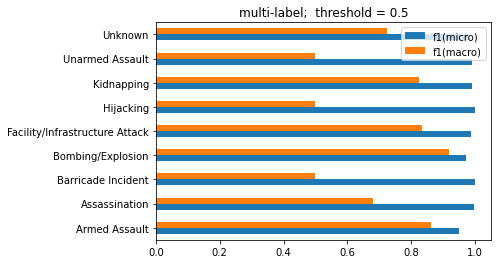

In [23]:
df_select = df[df.type.isin(df_target.columns[1:]) ]
df_select = df_select[df_select.threshold == 0.7][['type','f1(micro)','f1(macro)']]
df_select = df_select.reset_index(drop=True)
print(df_select)
ax = df_select.plot.barh(title = 'multi-label;  threshold = 0.5');
ax.set_yticklabels(df_target.columns[1:]);

In [24]:
exit()